In [3]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import Counter
import string 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer  

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, confusion_matrix, classification_report



import time


nltk.download('stopwords')
nltk.download('wordnet')  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
train_dataset = pd.read_csv('/content/train.csv')
test_dataset = pd.read_csv('/content/test.csv')
test_labels = pd.read_csv('/content/test_labels.csv')

EDA

In [6]:
train_dataset.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems

In [7]:
class_counts = train_dataset.iloc[:, 2:].sum()
class_counts

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

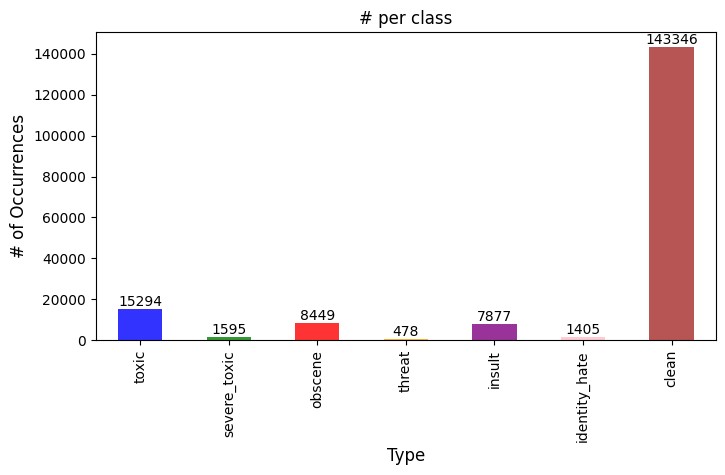

In [8]:
# Marking comments without any tags as "clean"
rowsums = train_dataset.iloc[:,2:].sum(axis=1)
train_dataset['clean'] = (rowsums==0)

# Get the sum of each column starting from the third column (tags)
class_counts = train_dataset.iloc[:, 2:].sum()

colors = ['blue', 'green', 'red', 'orange', 'purple', 'pink', 'brown']

# Create a bar plot
ax = class_counts.plot(kind='bar', alpha=0.8, color=colors, figsize=(8, 4))

# Set the plot title and axis labels
ax.set_title('# per class')
ax.set_ylabel('# of Occurrences', fontsize=12)
ax.set_xlabel('Type', fontsize=12)

# Add the counts above each bar
for i, v in enumerate(class_counts):
    ax.text(i, v+5, str(v), ha='center', va='bottom')

plt.show()


We can see that we have multliple tags for some comments. Only ~10% of the total comments have some sort of toxicity in them. 

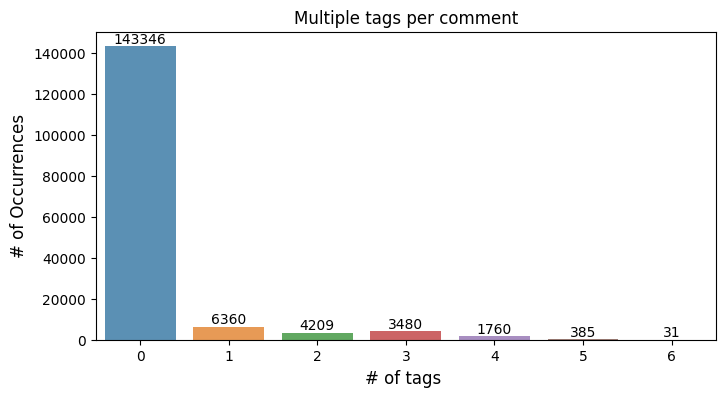

In [9]:
x = rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [10]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   clean          159571 non-null  bool  
dtypes: bool(1), int64(6), object(2)
memory usage: 9.9+ MB


In [11]:
train_dataset.describe()

toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

We can see that the distribution of word counts in the comment_text columns. most of the comments contain 0-100 words. this will indicate how to truncate this coumns in the preproccsing section.

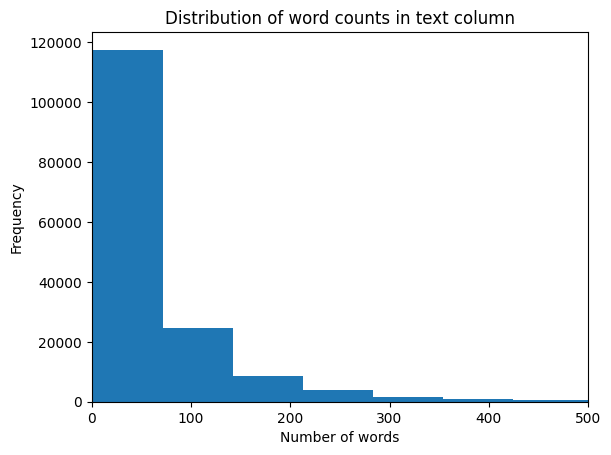

In [12]:
word_counts = train_dataset['comment_text'].apply(lambda text: len(text.split()))

# Plot a histogram of the word counts
plt.hist(word_counts, bins=20)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Distribution of word counts in text column')
plt.xlim(0, 500)
plt.show()

In [13]:
# Class Imbalance
x = train_dataset.iloc[:,2:].sum()


# Count number of clean entries
train_dataset['clean'].sum()

print("Total comments = ",len(train_dataset))
print("Total clean comments = ",train_dataset['clean'].sum())
print("Total tags =", x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 178444


we can see correlation between toxic tags. for example we can see that insult and obscene usuallt come together. 

<Axes: >

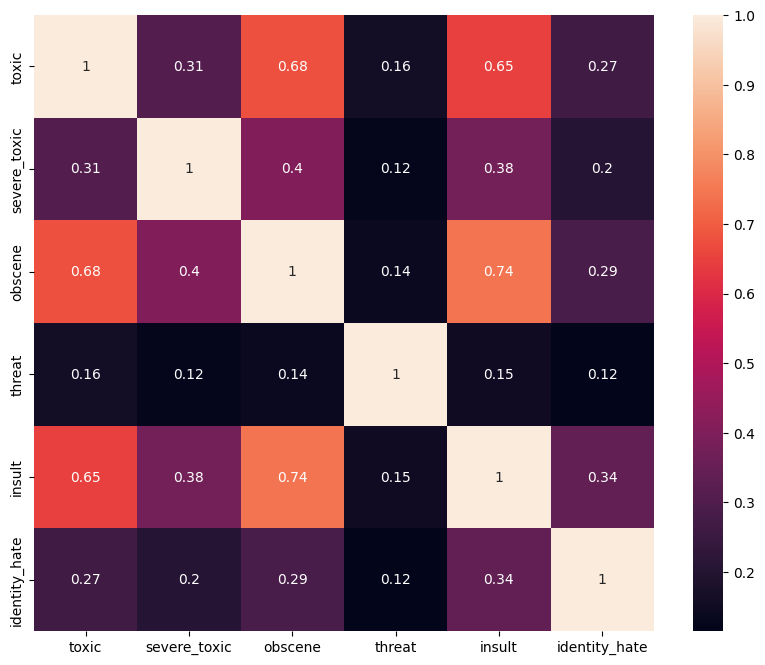

In [14]:
temp_df = train_dataset.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

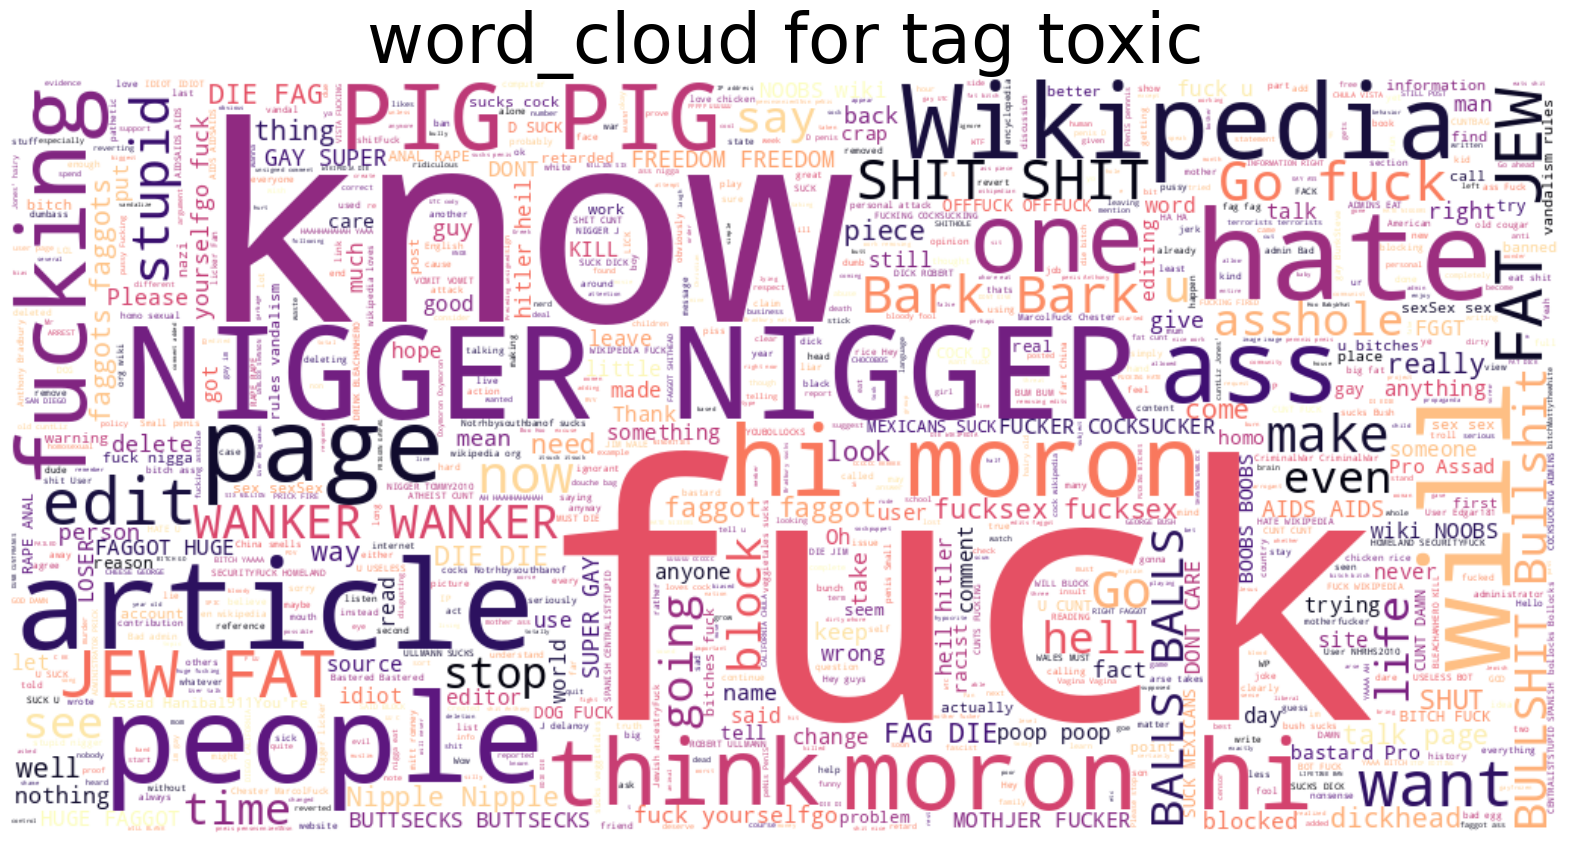

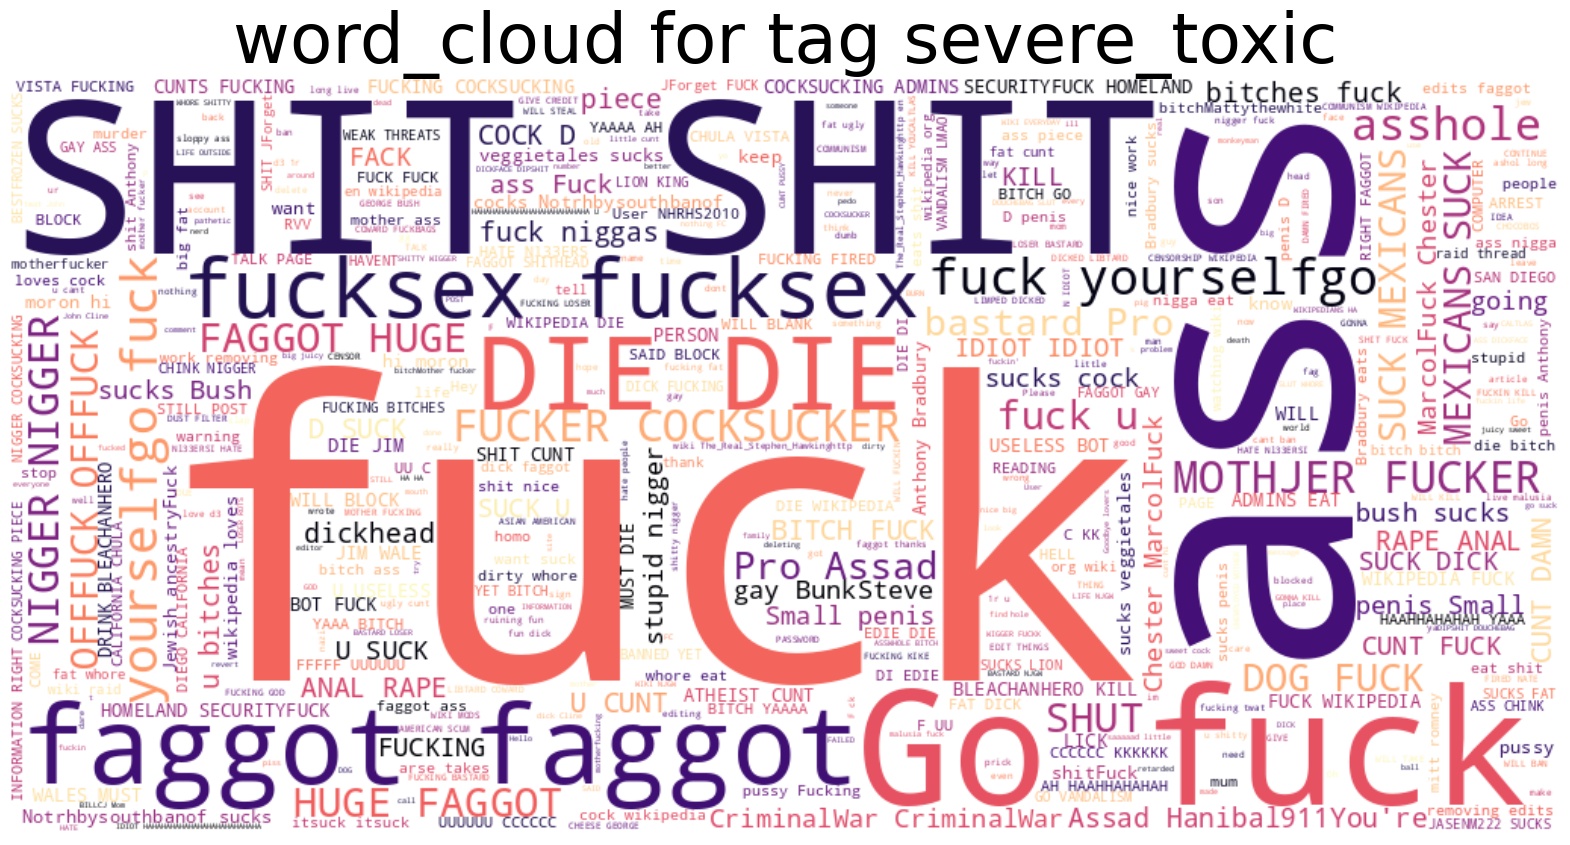

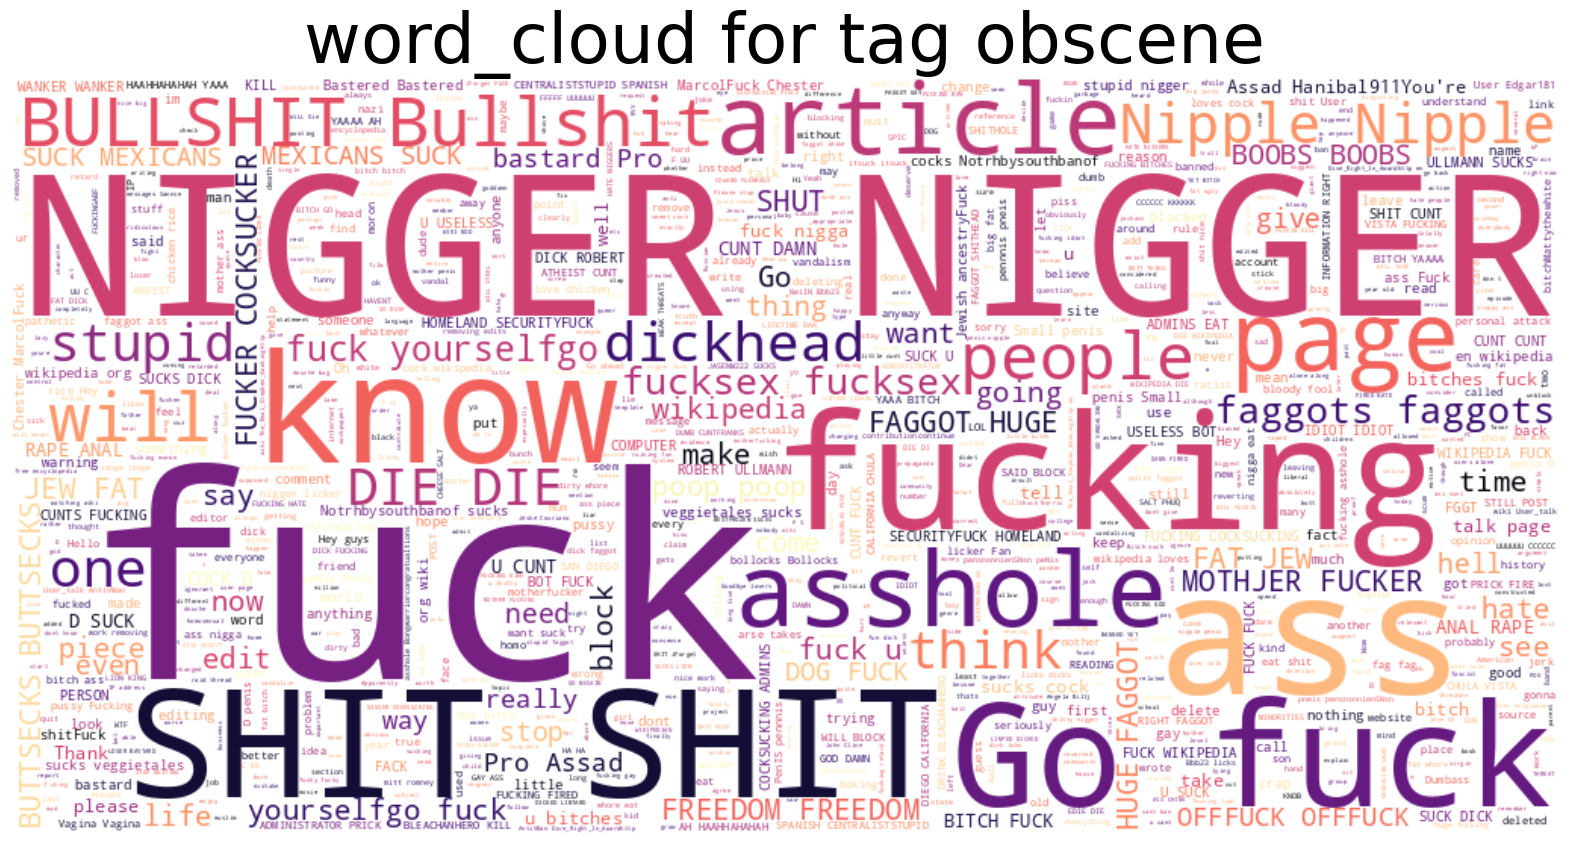

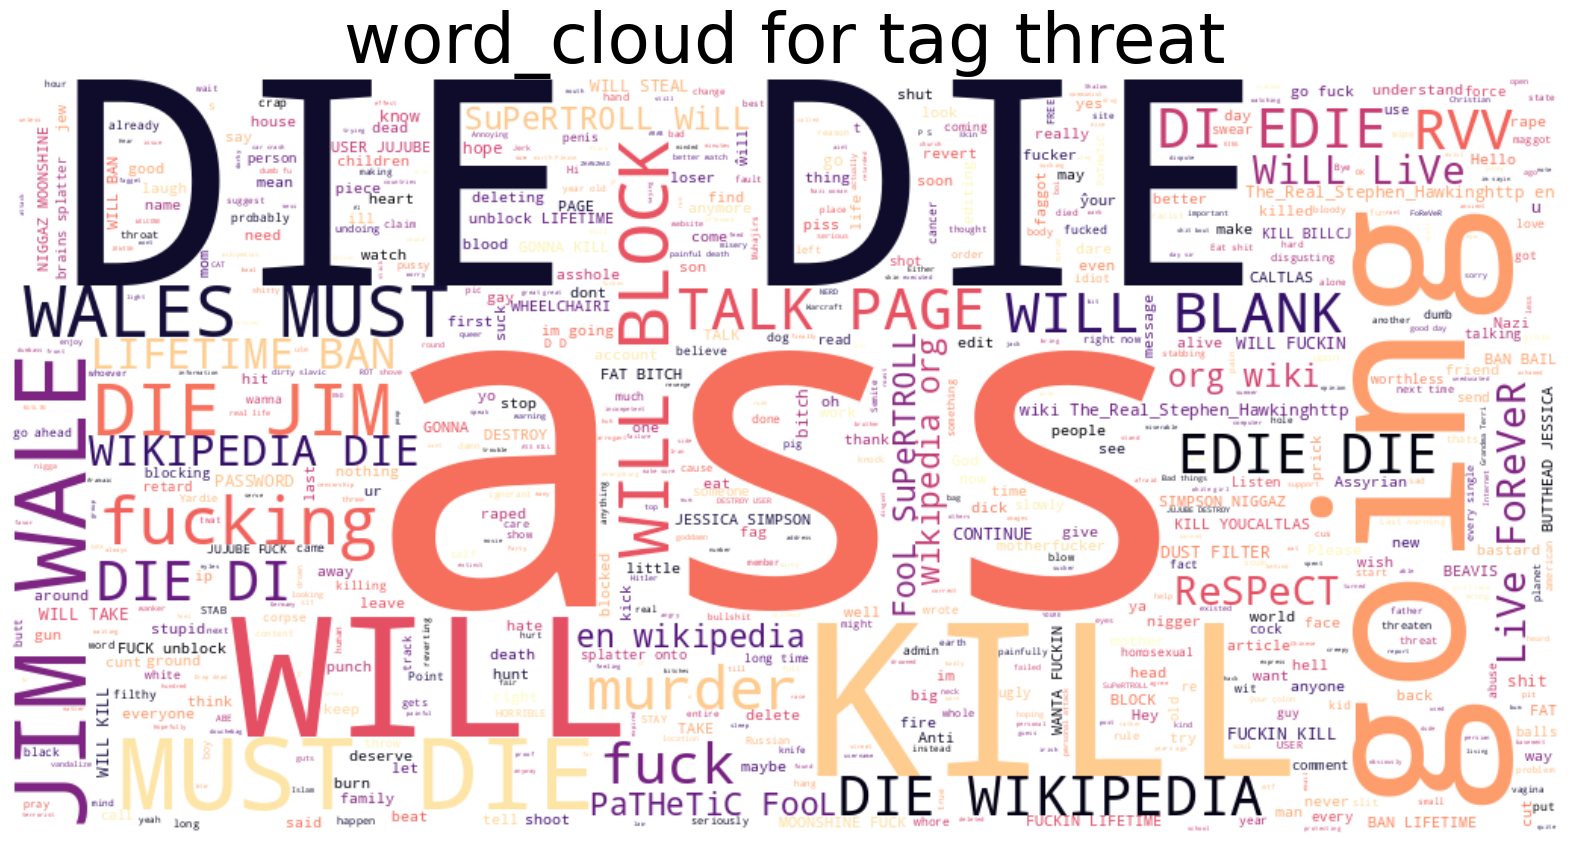

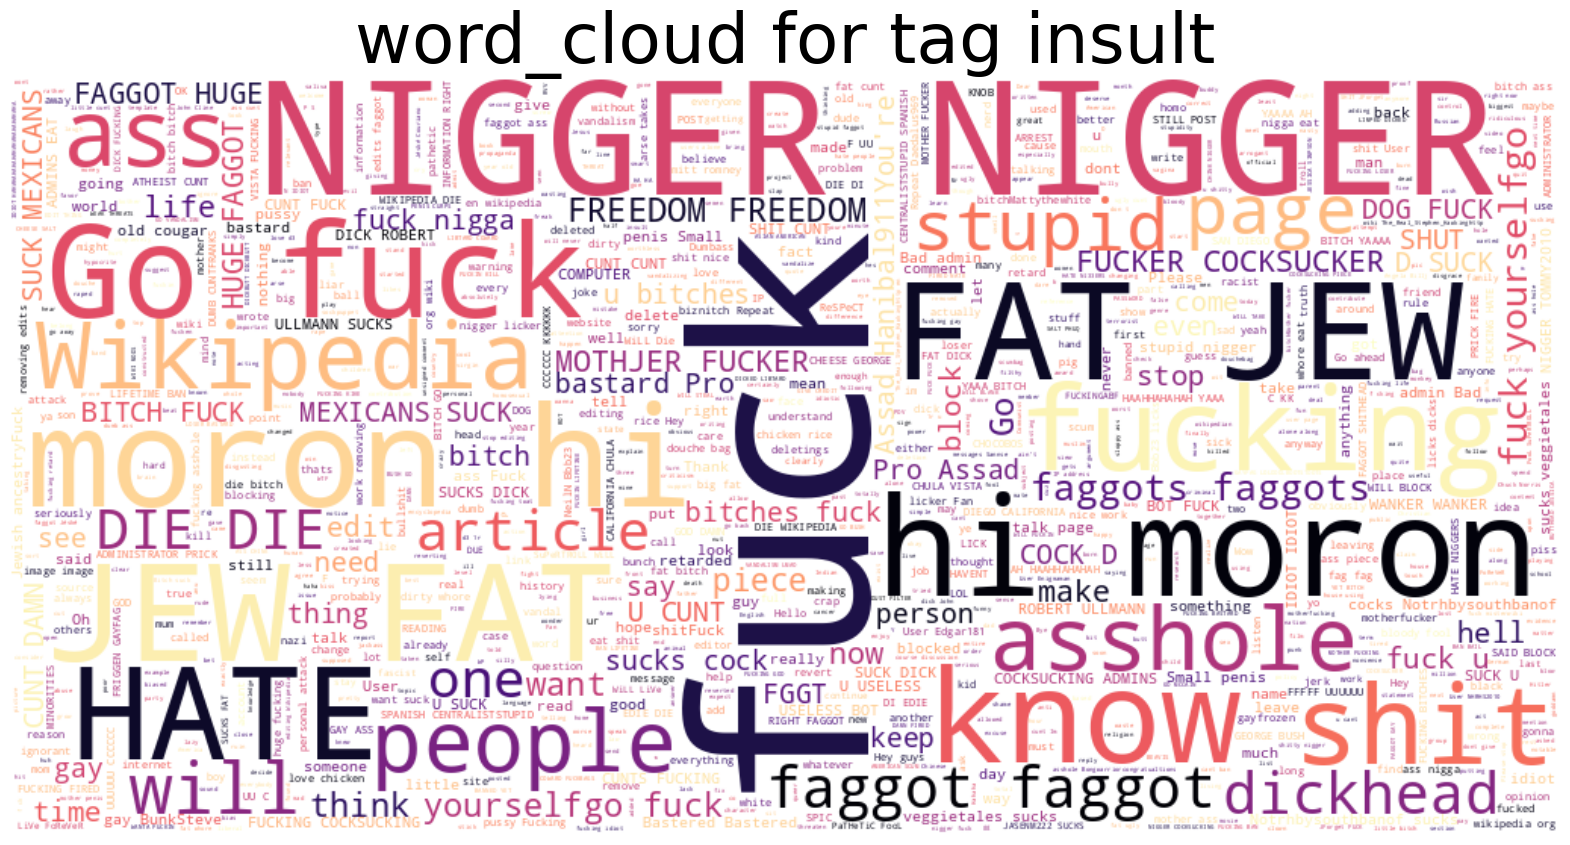

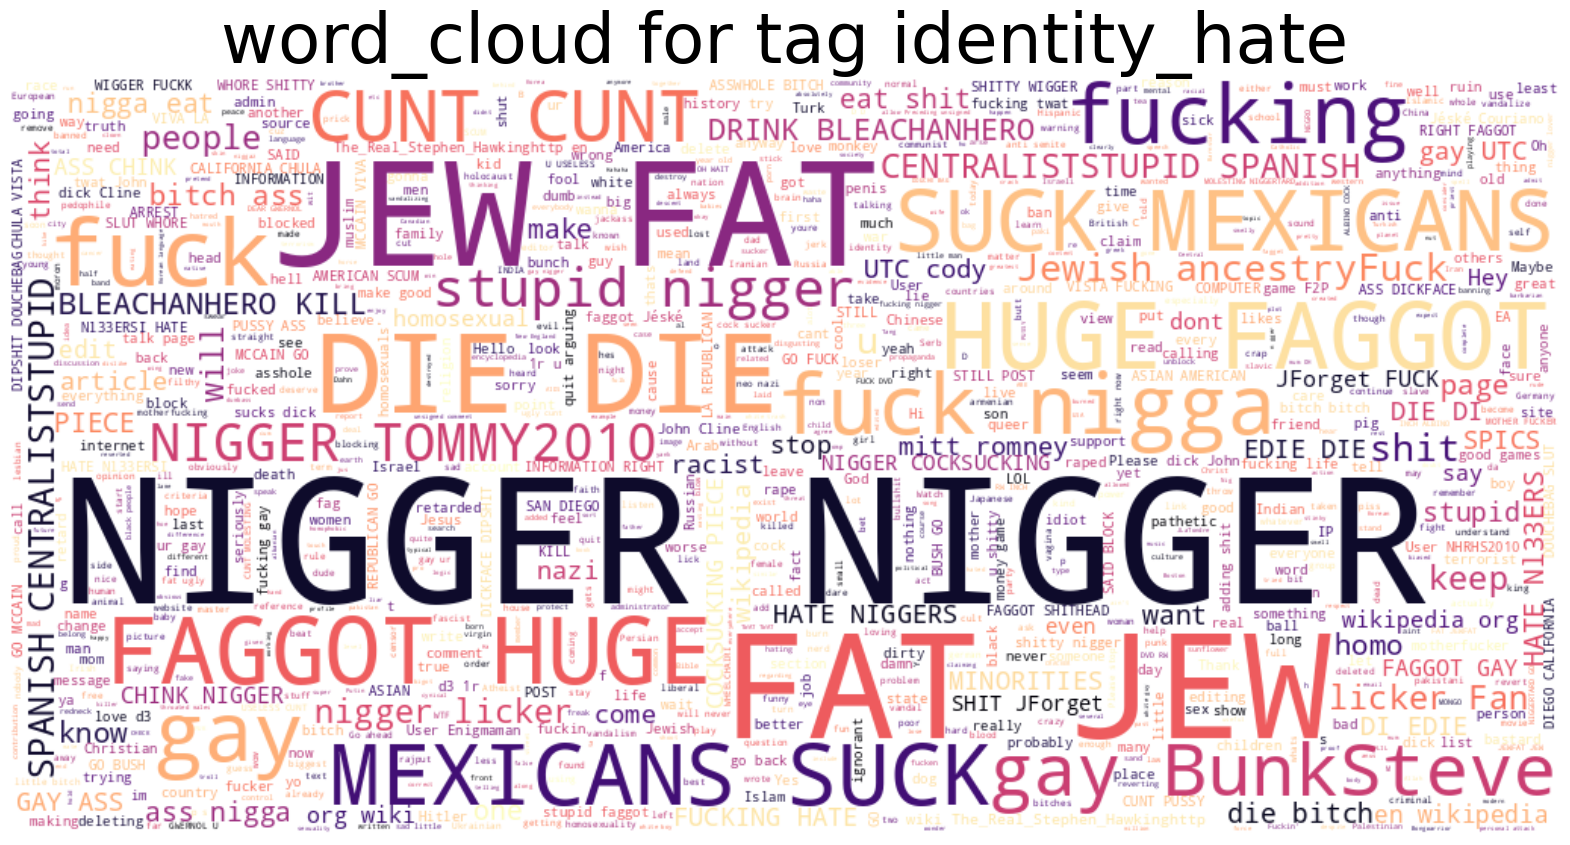

In [15]:
toxic_tags = train_dataset.iloc[:,2:-1]

for tag in toxic_tags.columns:
  text_tag = " ".join(item for item in train_dataset[train_dataset[tag] == 1]['comment_text'])
  stopwords = set(STOPWORDS)
  stopwords.update(["Paddock", "Paddocks"])

  wordcloud = WordCloud(background_color="white", 
                        max_words=1000,
                        width=1024, 
                        height=500,
                        colormap="magma"                      
                      ).generate(text_tag)

  plt.figure(figsize=(20,20))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f'word_cloud for tag {tag}', fontsize=50)
  plt.margins(x=0, y=0)
  plt.savefig(f"cloud_{tag}.png", format="png")
  plt.show()

Feature Engineering

In [16]:
merge_data = pd.concat([train_dataset.iloc[:,0:2],test_dataset.iloc[:,0:2]])
df_merged = merge_data.reset_index(drop=True)

In [17]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

df_merged['unique_word_count'] = df_merged['comment_text'].apply(lambda text: len(set(str(text).split())))
df_merged['word_count'] = df_merged['comment_text'].apply(lambda text: len(str(text).split()))
df_merged['count_sent'] = df_merged["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
df_merged["count_punctuations"] = df_merged["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_merged["count_stopwords"] = df_merged["comment_text"].apply(lambda x: len([c for c in str(x) if c in stop_words]))


In [18]:
# Word count percent in each comment
df_merged['word_unique_percent'] = df_merged['unique_word_count']*100/df_merged['word_count']

# Punct percent in each comment
df_merged['punct_percent'] = df_merged['count_punctuations']*100/df_merged['word_count']

In [19]:
train_feats = df_merged.iloc[0:len(train_dataset),]
test_feats = df_merged.iloc[len(test_dataset):,]

# Combine the toxic tags
train_tags = train_dataset.iloc[:,2:]
train_dataset_features = pd.concat([train_feats,train_tags],axis=1)

In [20]:
train_dataset_features.unique_word_count.describe()

count    159571.000000
mean         48.097323
std          54.436443
min           1.000000
25%          16.000000
50%          31.000000
75%          59.000000
max         816.000000
Name: unique_word_count, dtype: float64

In [21]:
train_dataset_features['unique_word_count'].loc[train_dataset_features['unique_word_count'] > 200] = 200
spammers = train_dataset_features[train_dataset_features['word_unique_percent'] < 30]

<ipython-input-21-663926f9c37e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_features['unique_word_count'].loc[train_dataset_features['unique_word_count'] > 200] = 200


We can see that only 128 comments are tagged as clean (most of the clean comments are not a spam), but if we look comments tagged as toxic, we can correalte it to spammers.

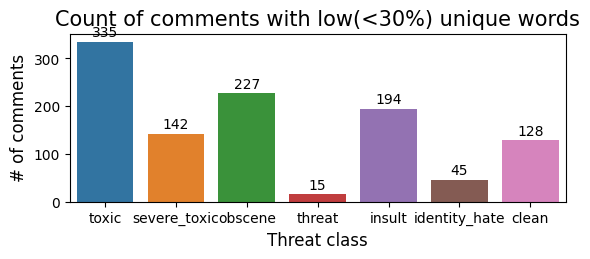

In [22]:
x = spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax = sns.barplot(x=x.index, y=x.values)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

In [23]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [24]:
lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [25]:
def clean_comment(comment):
    comment = comment.lower()
    comment = re.sub("\\n","",comment)
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    comment = re.sub("\[\[.*\]","",comment)
    
    # Split the sentences into words
    words = tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words = [APPO[word] if word in APPO else word for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in stop_words]
    
    clean_sent = " ".join(words)

    return (clean_sent)

In [26]:
df_merged['comment_text'] = df_merged.comment_text.apply(lambda comment: clean_comment(comment))

TF-IDF is calculated by multiplying the term frequency (TF) of a word by the inverse document frequency (IDF) of the word. The term frequency is the number of times a word appears in a document, while the inverse document frequency is the logarithmically scaled inverse fraction of the documents that contain the word.

The intuition behind TF-IDF is that if a word appears frequently in a document but rarely in the overall corpus, then it is likely to be more important or distinctive to that document. On the other hand, if a word appears frequently in both the document and the corpus, then it may not be as important or distinctive to the document.

In [27]:
train_gram, test_gram, features = list(), list(), list() 

for n_gram_range in [(1,1), (2,2)]:

  tfv = TfidfVectorizer(min_df=200,  max_features=10000, strip_accents='unicode', 
                        stop_words = 'english', ngram_range=n_gram_range)

  tfv.fit(df_merged['comment_text'])
  features.append(np.array(tfv.get_feature_names_out()))

  train_corpus = df_merged.iloc[0:len(train_dataset),]['comment_text']
  test_corpus = df_merged.iloc[len(train_dataset):]['comment_text']

  train_gram.append(tfv.transform(train_corpus))
  test_gram.append(tfv.transform(test_corpus))

In [28]:
def top_tfidf_feats(row, features, top_n=25):
    # Get top n tfidf values in row and return them with their corresponding feature names.
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['word', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important among documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''

    dfs = []
    for col in train_tags.columns:
        # Get the indices of rows relates to column with positive value.
        ids = train_tags.index[train_tags[col]==1]
        # Get a df with top n words with the highest tf-idf
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = col
        dfs.append(feats_df)

    return dfs

In [29]:
tfidf_top_n_per_lass_unigram = top_feats_by_class(train_gram[0], features[0])
tfidf_top_n_per_lass_2_gram = top_feats_by_class(train_gram[1], features[1])

Plot the top 10 words with the highest tf-idf per tag

In [30]:
train_tags.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')

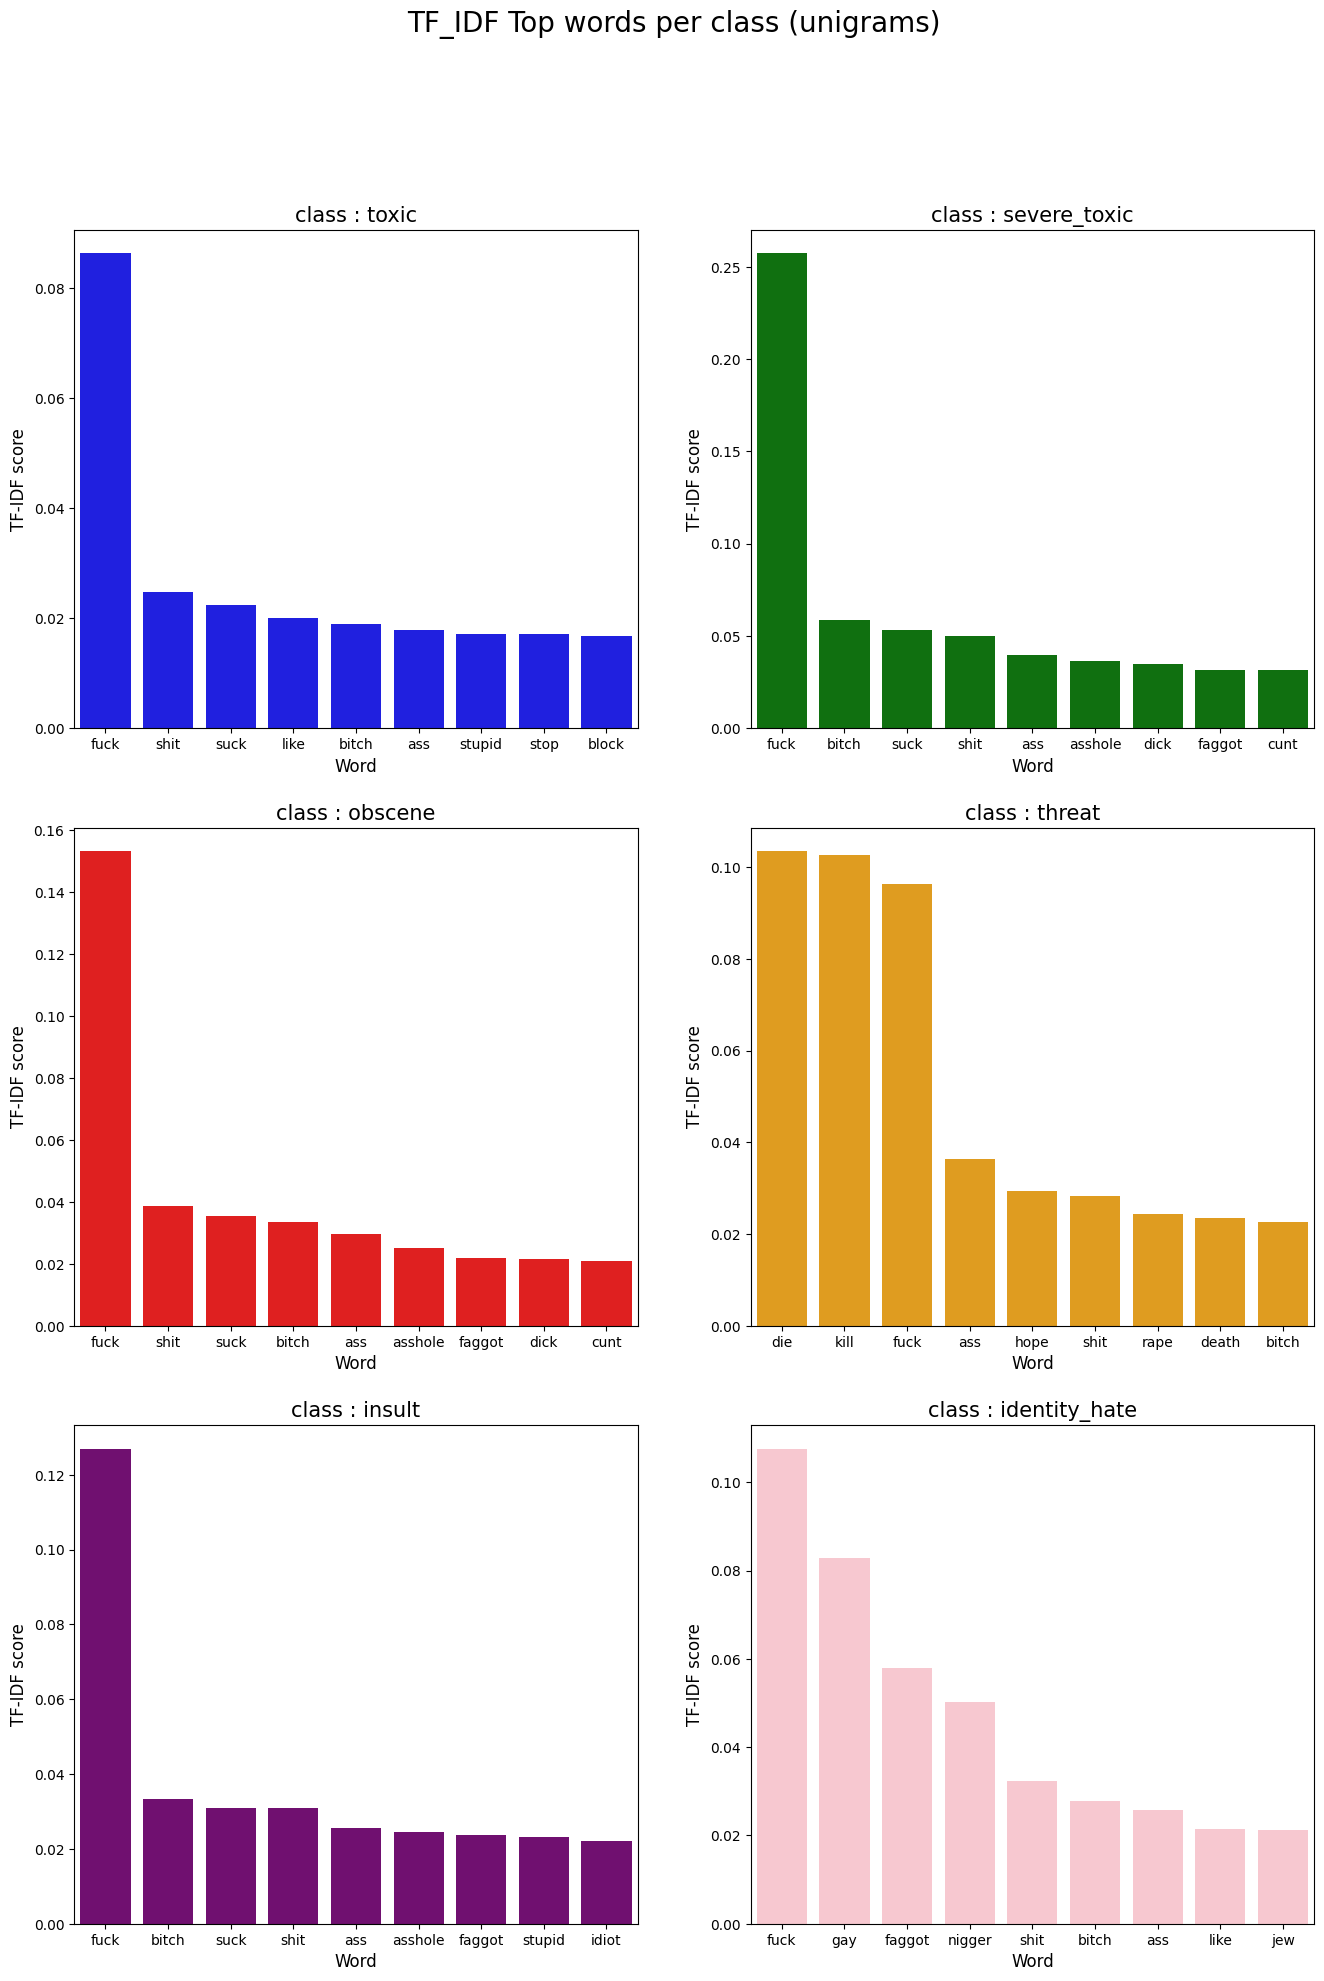

In [31]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(16,22))

plt.suptitle("TF_IDF Top words per class (unigrams)",fontsize=20)
gridspec.GridSpec(3,2)


plot_location = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, tag_name in enumerate(train_tags.columns[:-1]):
  plt.subplot2grid((3,2),plot_location[i])
  sns.barplot(x=tfidf_top_n_per_lass_unigram[i].word.iloc[0:9],
              y=tfidf_top_n_per_lass_unigram[i].tfidf.iloc[0:9],
              color=colors[i])
  plt.title(f"class : {tag_name}", fontsize=15)
  plt.xlabel('Word', fontsize=12)
  plt.ylabel('TF-IDF score', fontsize=12)


plt.show()

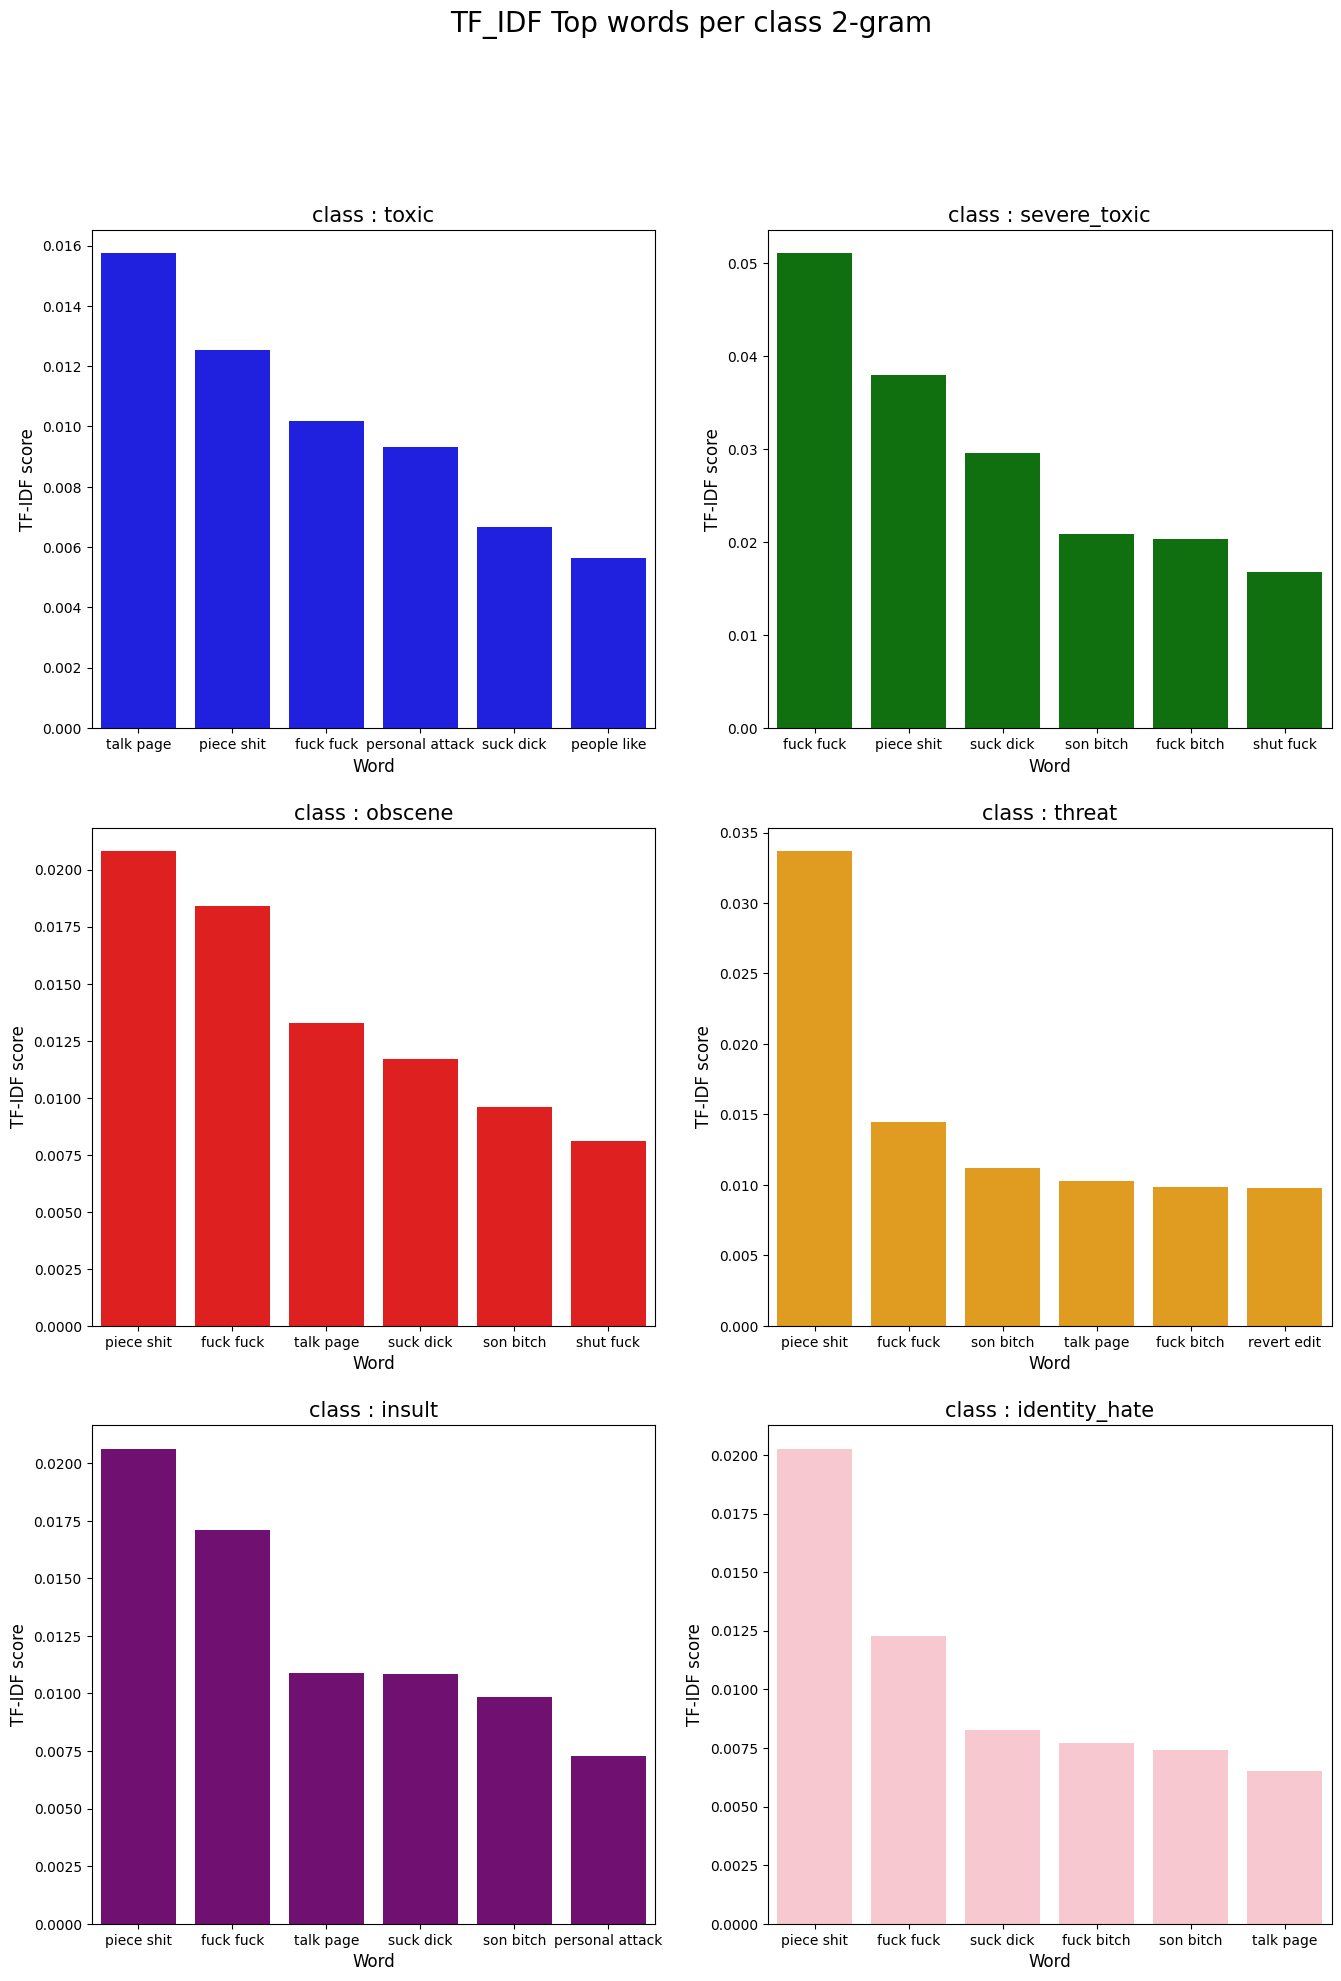

In [32]:
plt.figure(figsize=(16,22))

plt.suptitle("TF_IDF Top words per class 2-gram", fontsize=20)
gridspec.GridSpec(3,2)


plot_location = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, tag_name in enumerate(train_tags.columns[:-1]):
  plt.subplot2grid((3,2),plot_location[i])
  sns.barplot(x=tfidf_top_n_per_lass_2_gram[i].word.iloc[0:6],
              y=tfidf_top_n_per_lass_2_gram[i].tfidf.iloc[0:6],
              color=colors[i])
  plt.title(f"class : {tag_name}", fontsize=15)
  plt.xlabel('Word', fontsize=12)
  plt.ylabel('TF-IDF score', fontsize=12)


plt.show()

Model - Logistic Regression

In [59]:
train_columns = ['unique_word_count', 'word_count',
       'count_sent', 'punct_percent', 'count_stopwords', 'count_punctuations',
       'word_unique_percent']

X = train_dataset_features[train_columns]
y = train_dataset_features.iloc[:,9:15]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

Class:= toxic
Trainloss=log loss: 0.6523655143464883
Test=log loss: 0.6544566255846012


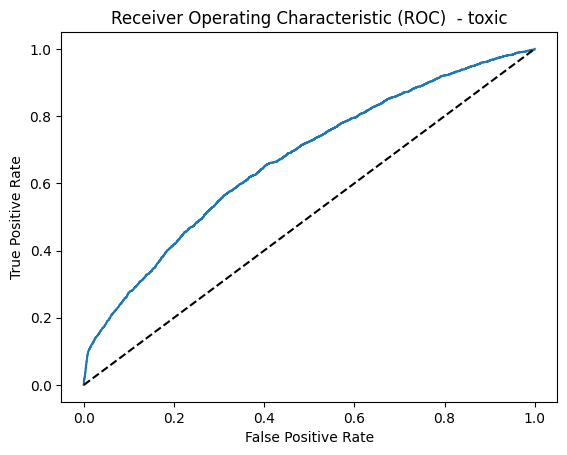

Confusion Matrix:
[[14414 14485]
 [  830  2186]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.50      0.65     28899
           1       0.13      0.72      0.22      3016

    accuracy                           0.52     31915
   macro avg       0.54      0.61      0.44     31915
weighted avg       0.87      0.52      0.61     31915

Class:= severe_toxic
Trainloss=log loss: 0.5821822235209302
Test=log loss: 0.5753170226426091


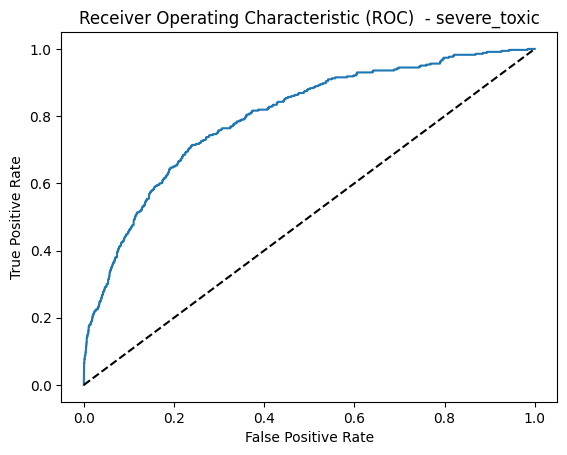

Confusion Matrix:
[[19634 11938]
 [   63   280]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77     31572
           1       0.02      0.82      0.04       343

    accuracy                           0.62     31915
   macro avg       0.51      0.72      0.41     31915
weighted avg       0.99      0.62      0.76     31915

Class:= obscene
Trainloss=log loss: 0.6474230258448513
Test=log loss: 0.6455749668952158


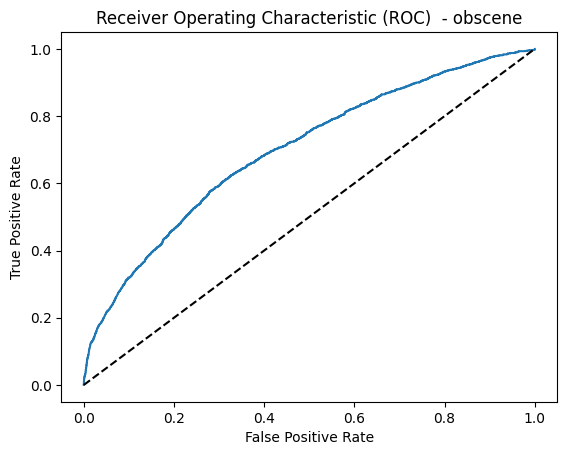

Confusion Matrix:
[[15589 14676]
 [  430  1220]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.52      0.67     30265
           1       0.08      0.74      0.14      1650

    accuracy                           0.53     31915
   macro avg       0.52      0.63      0.41     31915
weighted avg       0.93      0.53      0.65     31915

Class:= threat
Trainloss=log loss: 0.6358218779468683
Test=log loss: 0.6360200078155911


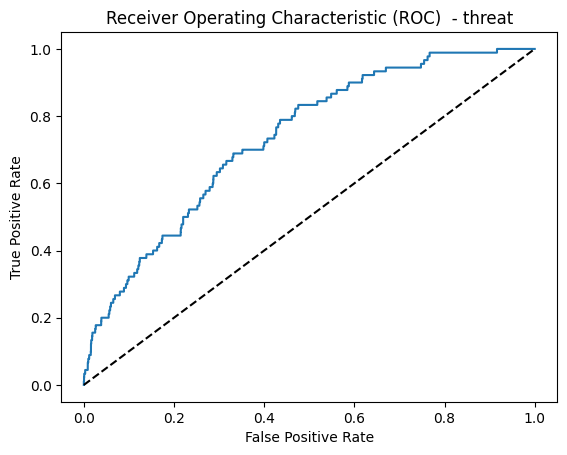

Confusion Matrix:
[[19306 12519]
 [   27    63]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.61      0.75     31825
           1       0.01      0.70      0.01        90

    accuracy                           0.61     31915
   macro avg       0.50      0.65      0.38     31915
weighted avg       1.00      0.61      0.75     31915

Class:= insult
Trainloss=log loss: 0.6486084275758175
Test=log loss: 0.646028221356051


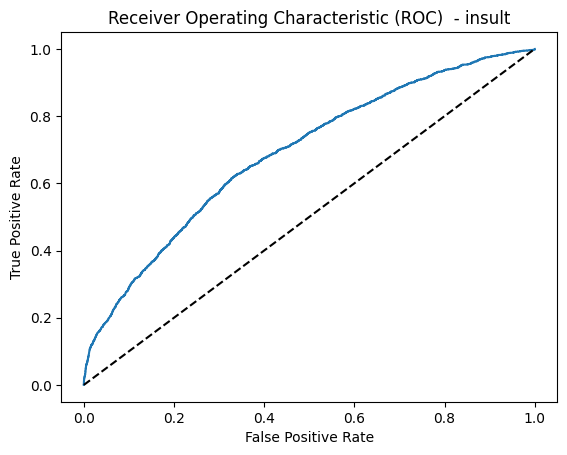

Confusion Matrix:
[[15425 14926]
 [  403  1161]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.51      0.67     30351
           1       0.07      0.74      0.13      1564

    accuracy                           0.52     31915
   macro avg       0.52      0.63      0.40     31915
weighted avg       0.93      0.52      0.64     31915

Class:= identity_hate
Trainloss=log loss: 0.6558167659023256
Test=log loss: 0.6556531599902988


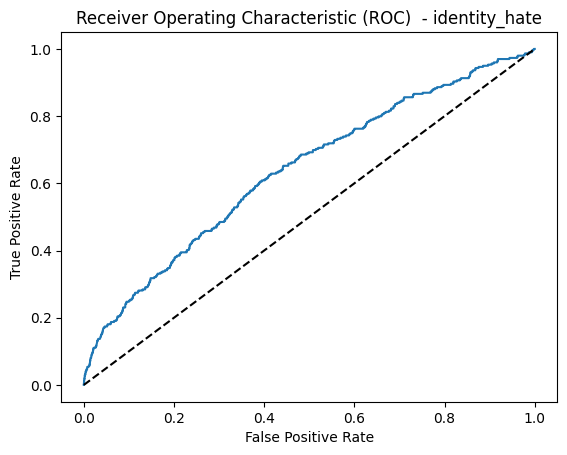

Confusion Matrix:
[[15187 16429]
 [   89   210]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.48      0.65     31616
           1       0.01      0.70      0.02       299

    accuracy                           0.48     31915
   macro avg       0.50      0.59      0.34     31915
weighted avg       0.98      0.48      0.64     31915

mean column-wise log loss:Train dataset 0.6370363058562136
mean column-wise log loss:Test dataset 0.6355083340473945


In [63]:
model = LogisticRegression(C=3, class_weight='balanced')

train_loss, test_loss, importance = list(), list(), list()

preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_test = np.zeros((X_test.shape[0], len(y_test)))


for i, j in enumerate(y):
    print('Class:= '+j)

    model.fit(X_train, y_train[j])
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    preds_test[:,i] = model.predict_proba(X_test)[:,1]

    train_loss_class = log_loss(y_train[j], preds_train[:,i])
    test_loss_class = log_loss(y_test[j], preds_test[:,i])

    print('Trainloss=log loss:', train_loss_class)
    print('Test=log loss:', test_loss_class)

    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    test_loss.append(test_loss_class)

    y_pred = model.predict(X_test)

    # Compute and plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test[j], preds_test[:,i])
    roc_auc = roc_auc_score(y_test[j], preds_test[:,i])

    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC)  - {j}')
    plt.show()

    # Compute and print some metrics
    print(f'Confusion Matrix:\n{confusion_matrix(y_test[j], y_pred)}\n')
    print(f'Classification Report:\n{classification_report(y_test[j], y_pred)}')


print('mean column-wise log loss:Train dataset', np.mean(train_loss))



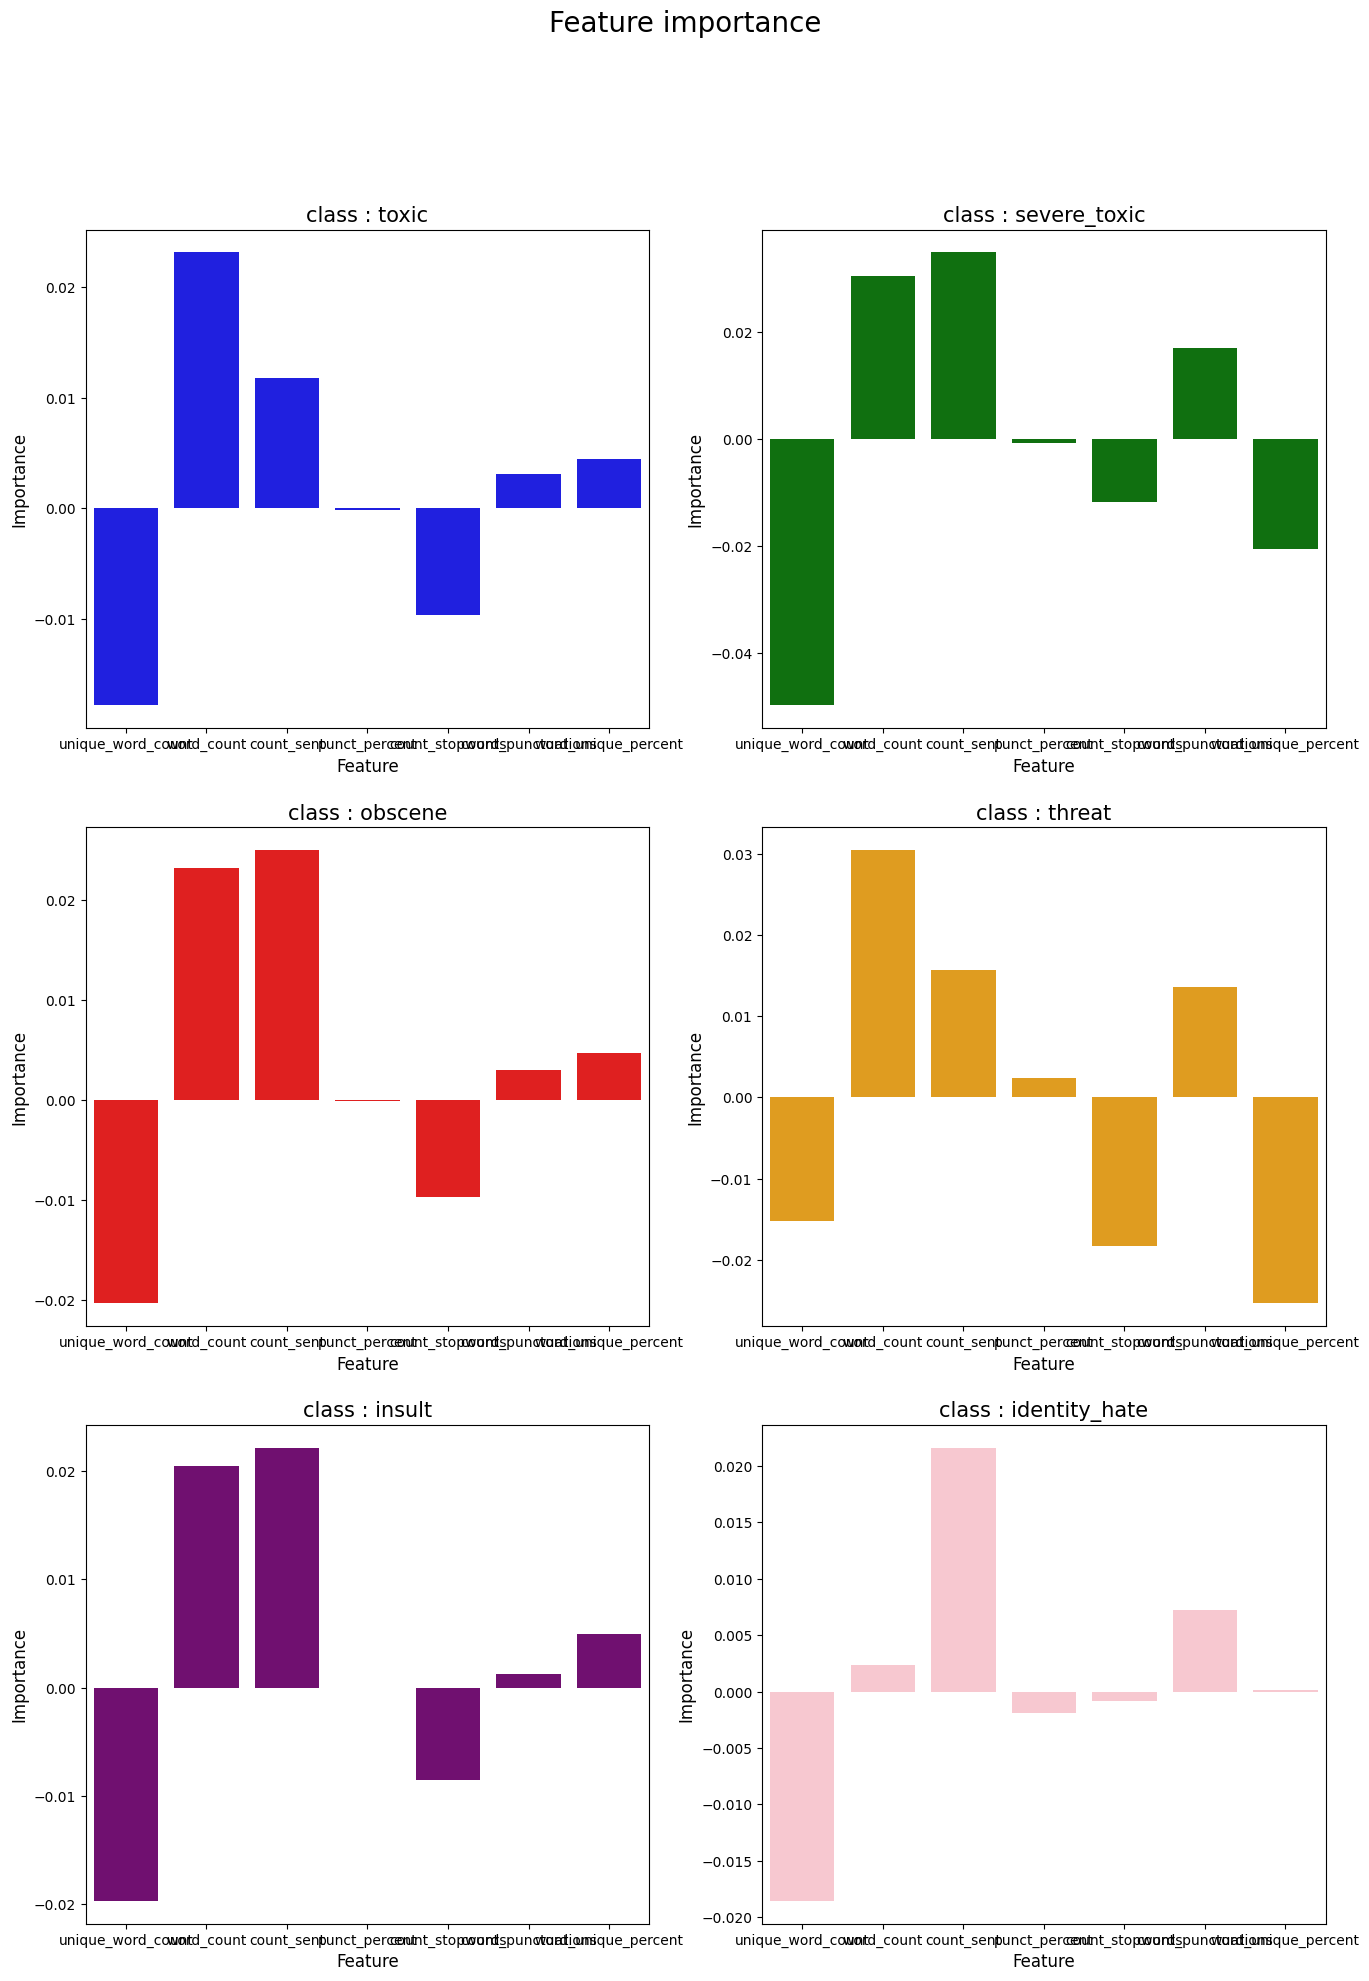

In [64]:
plt.figure(figsize=(16,22))

plt.suptitle("Feature importance", fontsize=20)
gridspec.GridSpec(3,2)


plot_location = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, tag_name in enumerate(train_tags.columns[:-1]):
  plt.subplot2grid((3,2),plot_location[i])
  sns.barplot(x=train_columns,
              y=importance[i][0],
              color=colors[i])
  plt.title(f"class : {tag_name}", fontsize=15)
  plt.xlabel('Feature', fontsize=12)
  plt.ylabel('Importance', fontsize=12)


plt.show()